# FIRE 398 Fall 2022
## Anthony Louie

# Introduction

The purpose of this notebook is to use a learning model to isolate the sky from the rest of the image. Create a mask on the non-sky part of the iamge. And apply [inpainting](https://en.wikipedia.org/wiki/Inpainting) to remove obstructions from the iamge. This is one approach to cleaning the data within GLOBE Clouds and is a follow up to my data cleaning work from last semester. You can find that notebook [here](https://colab.research.google.com/drive/1Wh46Fu-Tt39SgCRgDYrs_4iyga0vVoGG?usp=sharing).

The learning model we are using is a classifier that seperates the image into different classes. More information about that below.

# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import urllib
import requests
import PIL
import skimage
import cv2
import colorsys
from PIL import Image
from io import BytesIO
from scipy import stats  
from skimage.color import rgb2hsv
from google.colab.patches import cv2_imshow

In [ ]:
!pip install imutils
import imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [ ]:
image_path = '/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/Images/image2823.jpg'

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open(image_path).convert('RGB')
img_original = imutils.resize(numpy.array(pil_image), height=450)
pil_image_rs = Image.fromarray(img_original)
img_data = pil_to_tensor(pil_image_rs)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

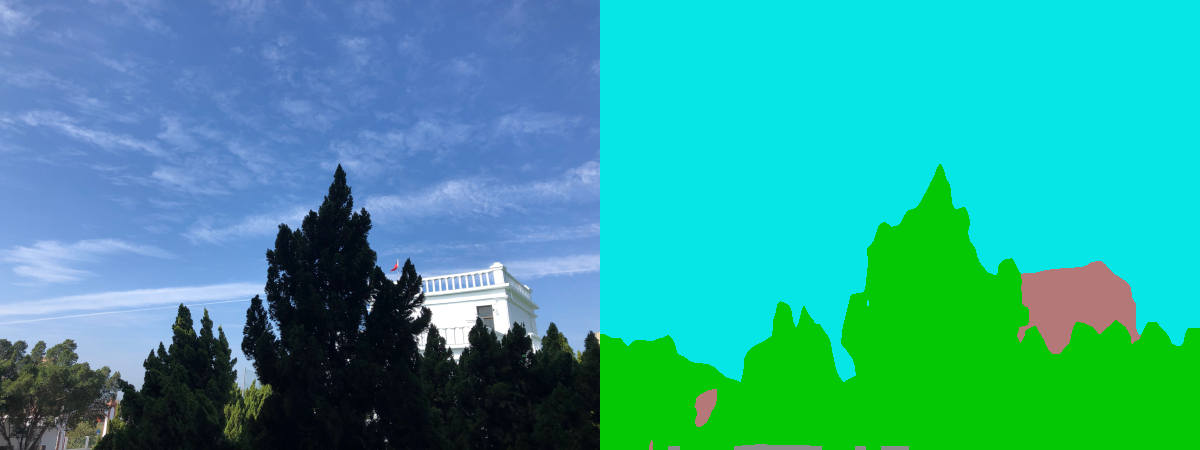

In [ ]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

sky:


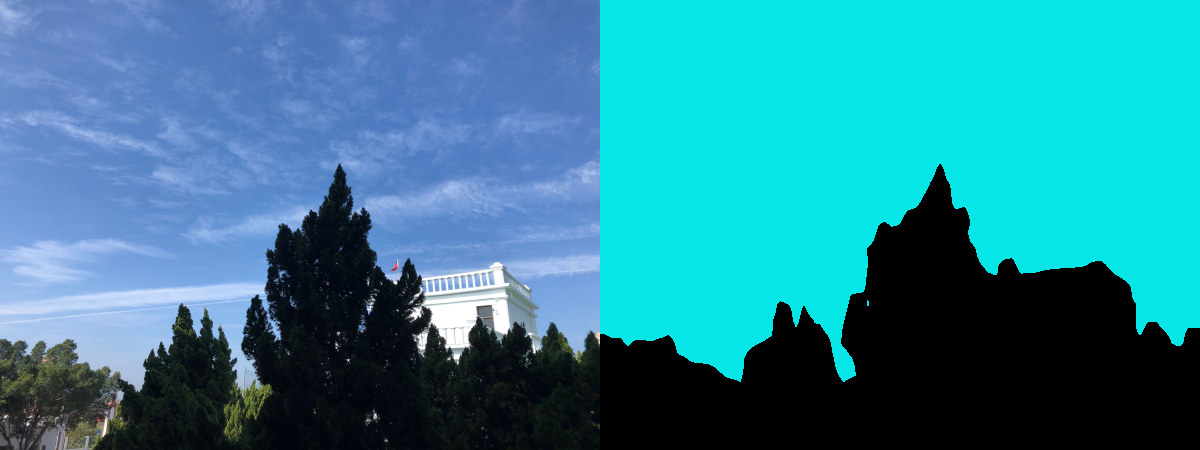

tree:


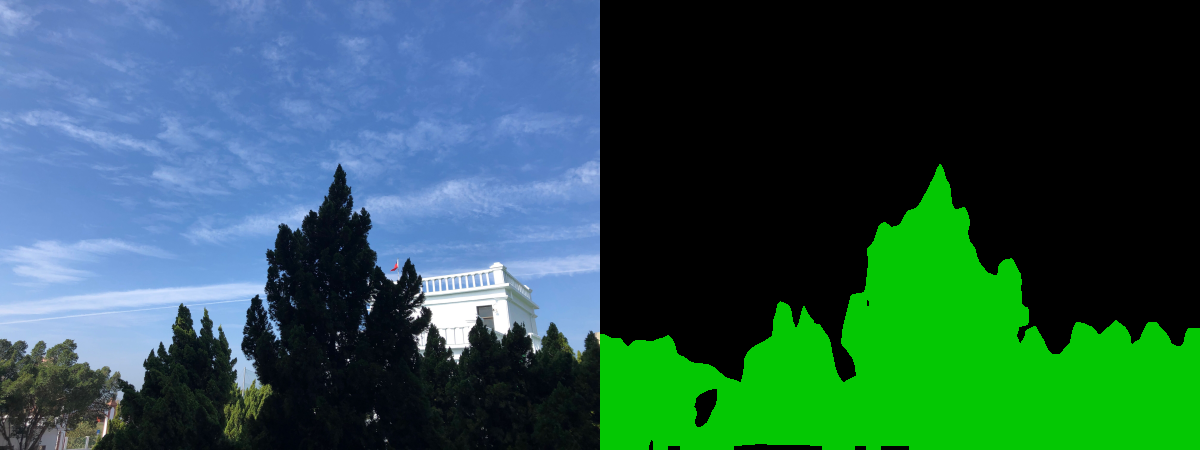

building:


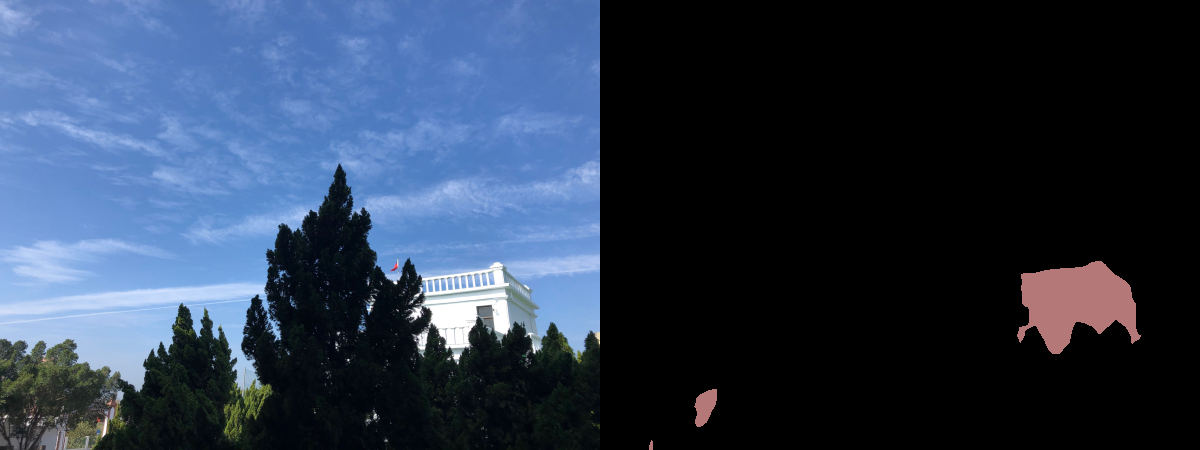

road:


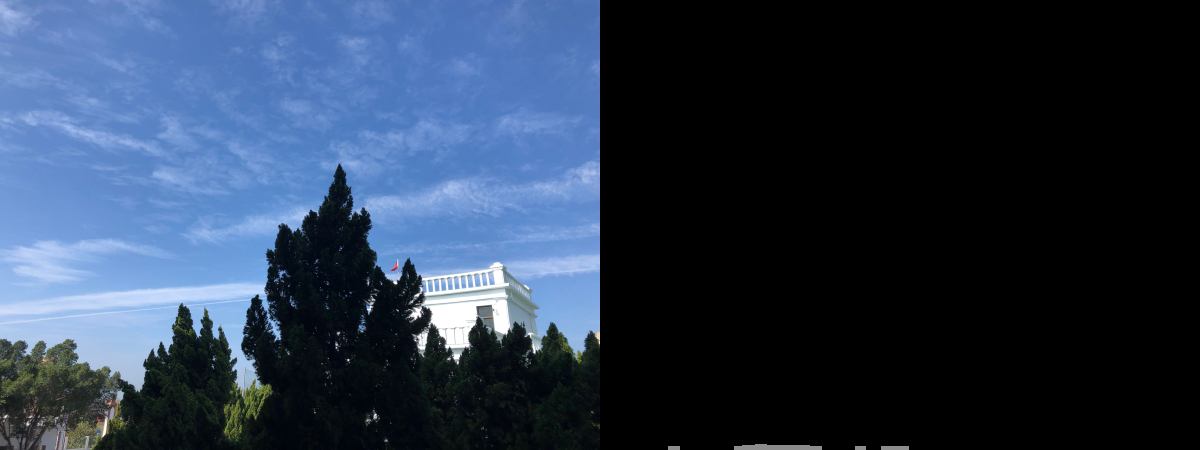

ceiling:


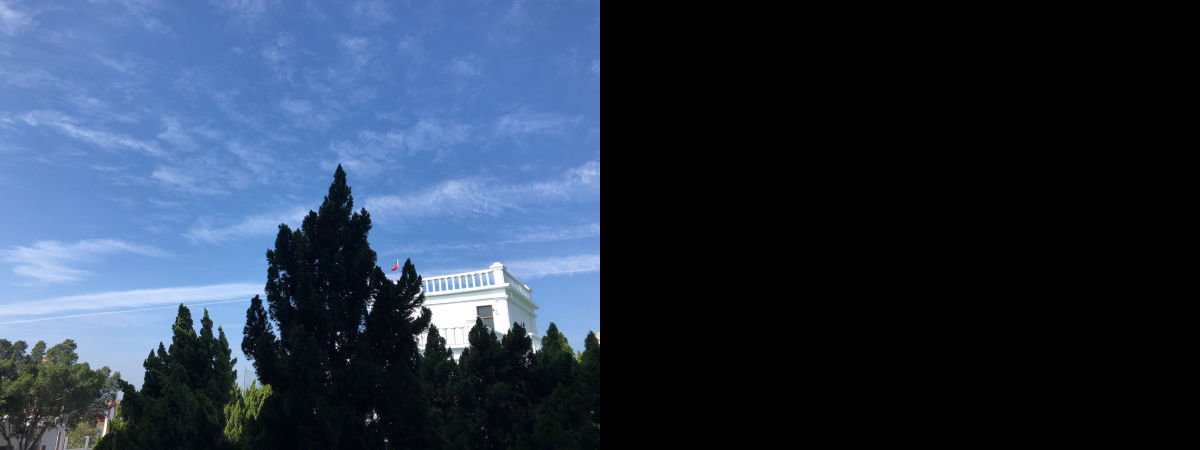

In [ ]:
# Top 5 classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:5]:
    visualize_result(img_original, pred, c)

The pretrained model does good at finding typcial obstructions found in the GLOBE Clouds data, such as trees and buildings. But some more specific obstructions to the dataset like telephone poles, power lines, are not trained and may not be seperated from the sky portion.

# Creating the Mask

The next step is to use the segmentated color mask and convert it to a binary (black and white) mask where the black will be the sky class and the rest will be considered an obstruction and be white.

In [ ]:
def get_mask(prediction):
  # get colored version of prediction
  pred_color = colorEncode(prediction, colors).astype(numpy.uint8)

  #convert color prediction into NumPy array for cv2 functions
  image_cv2 = np.array(pred_color)

  # find all pixels that match the value of sky color endcoding
  sky_pixel = np.array([6, 230, 230])
  isolate_sky = cv2.inRange(image_cv2, sky_pixel, sky_pixel)
  mask = cv2.bitwise_and(image_cv2, image_cv2, mask=isolate_sky)

  # convert to binary mask with white being obstructions and black being sky
  black_pixels_mask = np.all(mask == [0, 0, 0], axis=-1)
  non_black_pixels_mask = np.any(mask != [0, 0, 0], axis=-1)
  mask[black_pixels_mask] = [255, 255, 255]
  mask[non_black_pixels_mask] = [0, 0, 0]

  # apply dilation to mask
  kernel = np.ones((4,4),np.uint8) 
  dilated_mask = cv2.dilate(mask,kernel,iterations = 8) 

  # only need one of the layers in binary mask
  return mask[:,:,0], dilated_mask[:,:,0]

Number of white pixels: 91758
Number of black pixels: 178242
Ratio: 0.33984444444444445


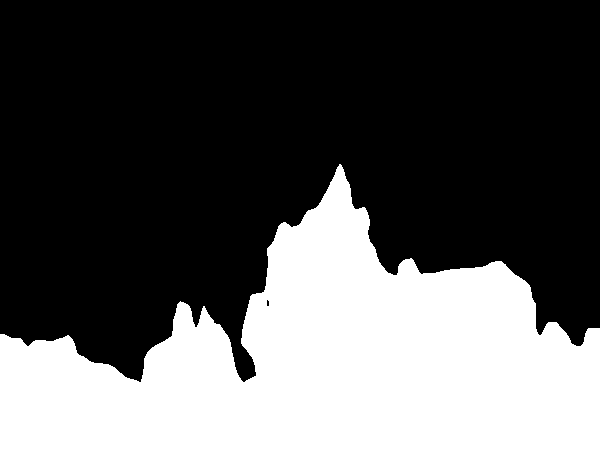

Number of white pixels: 104411
Number of black pixels: 165589
Ratio: 0.3867074074074074


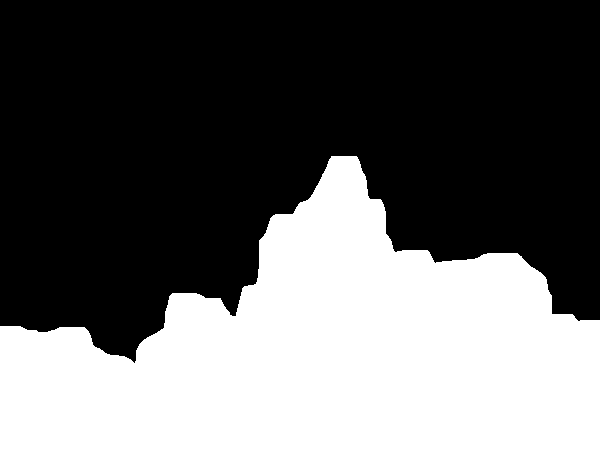

In [ ]:
mask, dilated_mask = get_mask(pred)

number_of_white_pix = np.sum(mask == 255)
number_of_black_pix = np.sum(mask == 0)
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)
print('Ratio:', number_of_white_pix / (number_of_white_pix + number_of_black_pix))
cv2_imshow(mask)

number_of_white_pix = np.sum(dilated_mask == 255)
number_of_black_pix = np.sum(dilated_mask == 0)
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)
print('Ratio:', number_of_white_pix / (number_of_white_pix + number_of_black_pix))
cv2_imshow(dilated_mask)

# Inpainting

Now we use the binary mask with the original color image and run inpainting.

In [ ]:
original = cv2.imread(image_path, -1)
original_rs = imutils.resize(original, height=450)

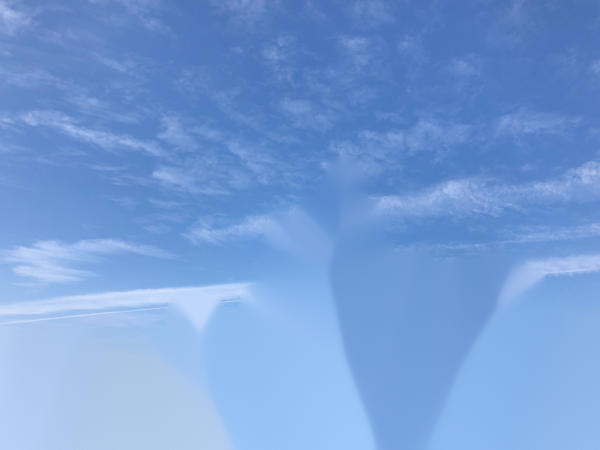

In [20]:
result = cv2.inpaint(original_rs,dilated_mask,8,cv2.INPAINT_TELEA)
result_rs = imutils.resize(result, height=450)
cv2_imshow(result_rs)

# Discusion

There are other methods of inpainting, some that use a learning approach and can be better at smoothing out parts. And that is a possible future step to take. I looked into some approaches but none seem compatible with the spcific library and python versions that this notebook uses.

An alternative is to have a seperate notebook run concurrently and have the output of the segmantation be the input to that notebook.